In [4]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp, cle_for_resmlp_v3
# from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers

org_model = resmlp_24_v4(pretrained=True).eval()


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [40]:
v1 = torch.load("ResMLP_S24_ReLU_fp32_80.602.pth")

new_model_dict = {}

for k, v in model1.state_dict().items():
    if "blocks" not in k:
        new_model_dict[k] = v


for i in range(24):
    gamma_w = None
    norm_w = None
    norm_b = None
    attn_w = None
    attn_b = None
    for k, v in model1.blocks[i].state_dict().items():
        # print(k)
        if "norm1.weight" in k:
            norm_w = v
        elif "norm1.bias" in k:
            norm_b = v
        elif "attn.weight" in k:
            attn_w = v
        elif "attn.bias" in k:
            attn_b = v
        elif "gamma_1.weight" in k:
            gamma_w = v
        else:
            new_model_dict[f"blocks.{i}.{k}"] = v
        
    new_model_dict[f"blocks.{i}.inner.weight"] = torch.diag(norm_w * gamma_w)
    new_model_dict[f"blocks.{i}.inner.bias"] = norm_b.repeat(196,1) @ gamma_w + torch.inverse(attn_w) @ attn_b.repeat(384,1).T @ gamma_w
    new_model_dict[f"blocks.{i}.outer.weight"] = attn_w
    
torch.save(new_model_dict, "ResMLP_S24_ReLU_v4.pth")


([<matplotlib.axis.XTick at 0x27a43764700>,
 [Text(1, 0, '23-inner'),
  Text(2, 0, '23-norm2'),
  Text(3, 0, '23-mlp.fc1'),
  Text(4, 0, '23-mlp.fc2')])

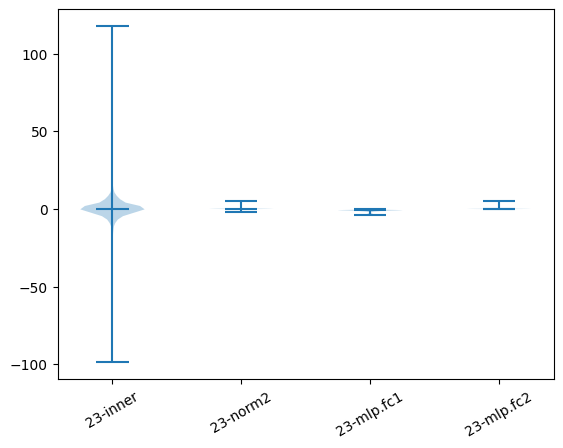

In [3]:
model_layers = []
for i in range(23, 24):
    todo_layer = org_model.blocks[i]
    model_layers.append(get_linear_layers(todo_layer, specify_names=None, prefix=f"{i}-"))
# print(model_layers[0].weight.detach().numpy().flatten())

data = []
labels = []
for layer in model_layers:
    for n, m in layer:
        val = m.bias
        if val is not None:
            data.append(val[val.nonzero(as_tuple=True)].detach().numpy().flatten())
            labels.append(n)

plt.violinplot(data, showmedians=True, showextrema=True)
plt.xticks(range(1, len(labels) + 1), labels, rotation=30)

In [25]:
r1 = W1.abs().max()
r2 = W2.abs().max()
sT = torch.sqrt(r1*r2)/r2

W2_new = W2 * sT
W1_new = W1 / sT
B1_new = B1 / sT

print(sT)

out3 = W2_new @ (x @ W1_new + B1_new)
torch.allclose(out3, out2, atol=1e-5)

tensor(1.9382, grad_fn=<DivBackward0>)


True

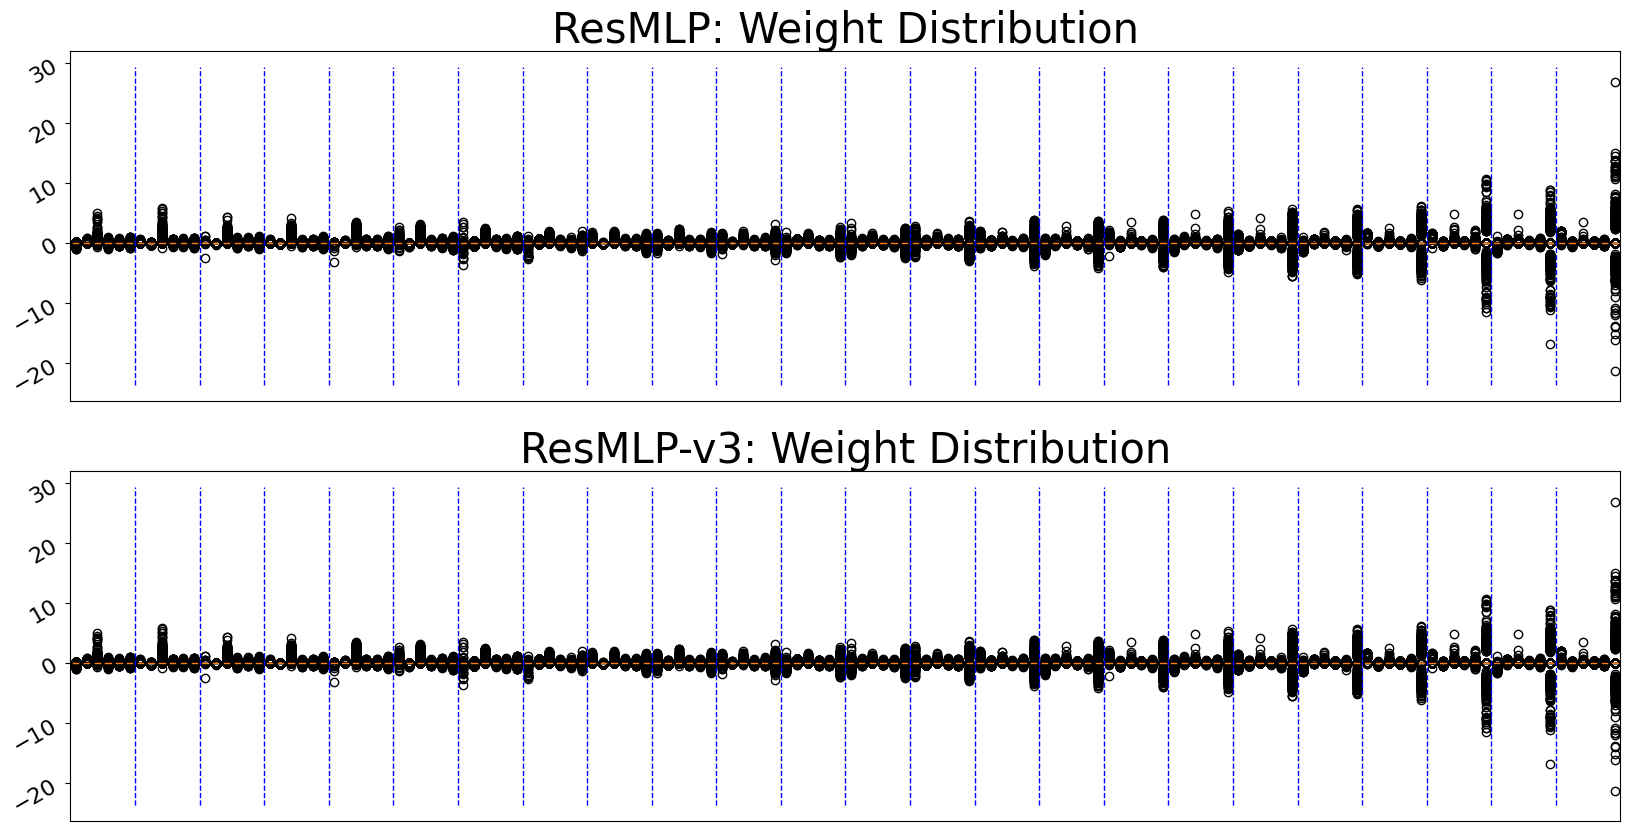

In [3]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(org_model, 0, 23, name="ResMLP: Weight Distribution", ax=ax[0], type="weight")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(org_model, 0, 23, name="ResMLP-v3: Weight Distribution", ax=ax[1], type="weight")

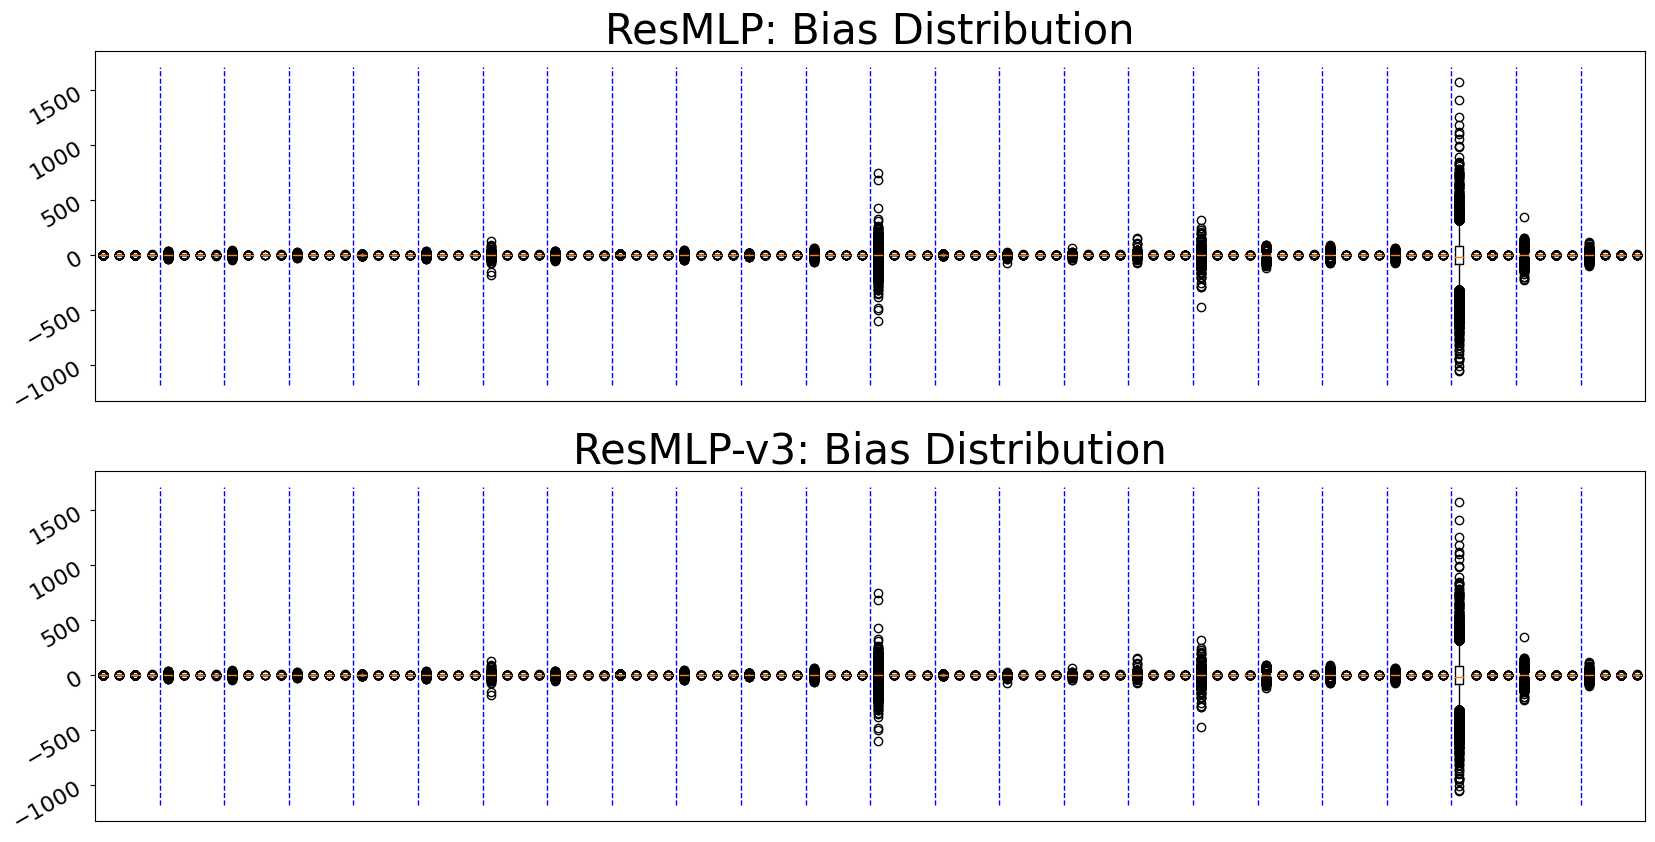

In [2]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
# model2.cpu()
layer_dist(org_model, 0, 23, name="ResMLP: Bias Distribution", ax=ax[0], type="bias")

# model2.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(org_model, 0, 23, name="ResMLP-v3: Bias Distribution", ax=ax[1], type="bias")

ValueError: Dimensions of labels and X must be compatible

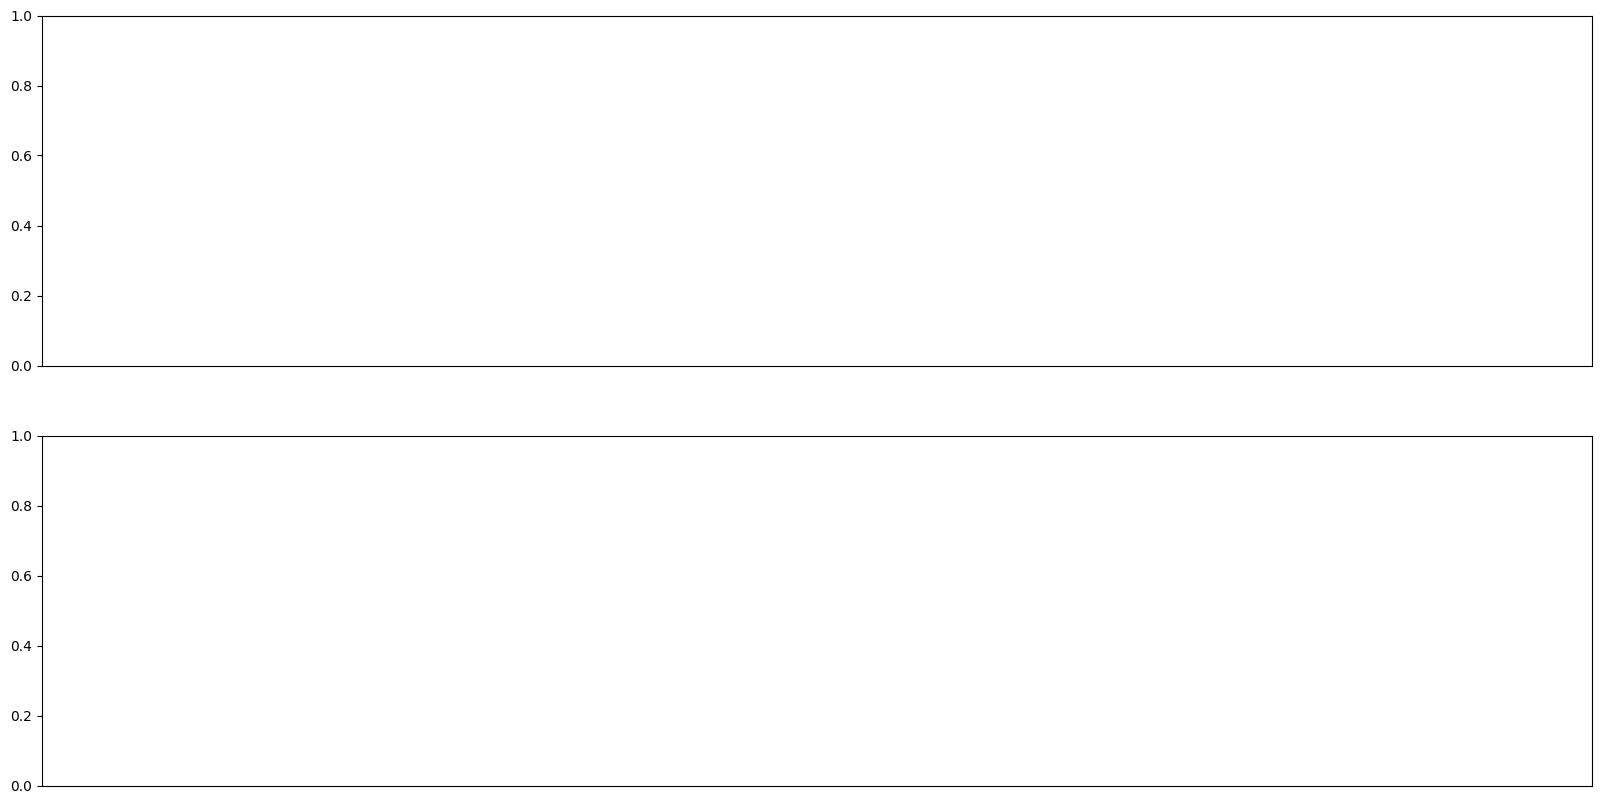

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
org_model.cpu()
layer_dist(org_model, 0, 23, name="ResMLP-v3: Bias Distribution - Inner", show_layers=["inner"], ax=ax[0], type="bias")

org_model.cpu()
# cle_for_resmlp_v3(model2)
layer_dist(org_model, 0, 23, name="ResMLP-v3: Bias Distribution - All", ax=ax[1], type="bias")
# act_dist(org_model, 0, 23, name='ResMLP-v3 0-23: Activation - Inner', show_layers=["inner"], ax=ax[1], real_sim=True)

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.336 ( 9.336)
Calibrate: [10/21]	Time  1.742 ( 2.388)
Calibrate: [20/21]	Time  0.193 ( 1.986)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.337 ( 9.337)
Calibrate: [10/21]	Time  2.128 ( 2.765)
Calibrate: [20/21]	Time  0.274 ( 2.363)


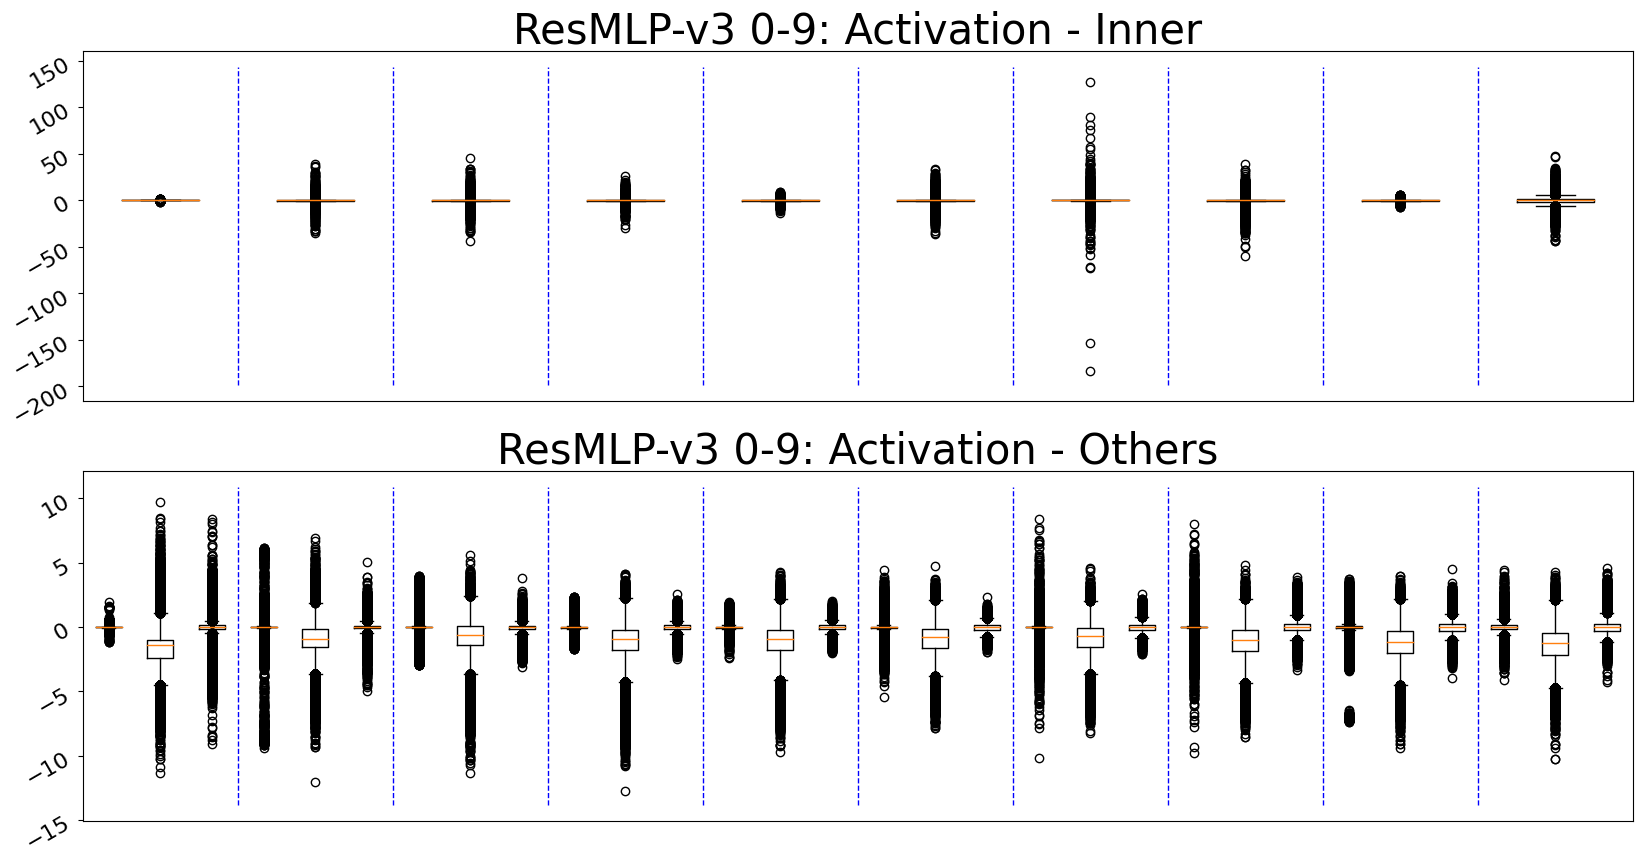

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
org_model.cuda()
act_dist(org_model, 0, 9, name='ResMLP-v3 0-9: Activation - Inner', show_layers=["inner"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
org_model.cuda()
act_dist(org_model, 0, 9, name='ResMLP-v3 0-9: Activation - Others', show_layers=["outer", "mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time 13.255 (13.255)
Calibrate: [10/21]	Time  0.483 ( 1.638)
Calibrate: [20/21]	Time  0.062 ( 1.054)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  8.708 ( 8.708)
Calibrate: [10/21]	Time  1.428 ( 2.090)
Calibrate: [20/21]	Time  0.200 ( 1.699)


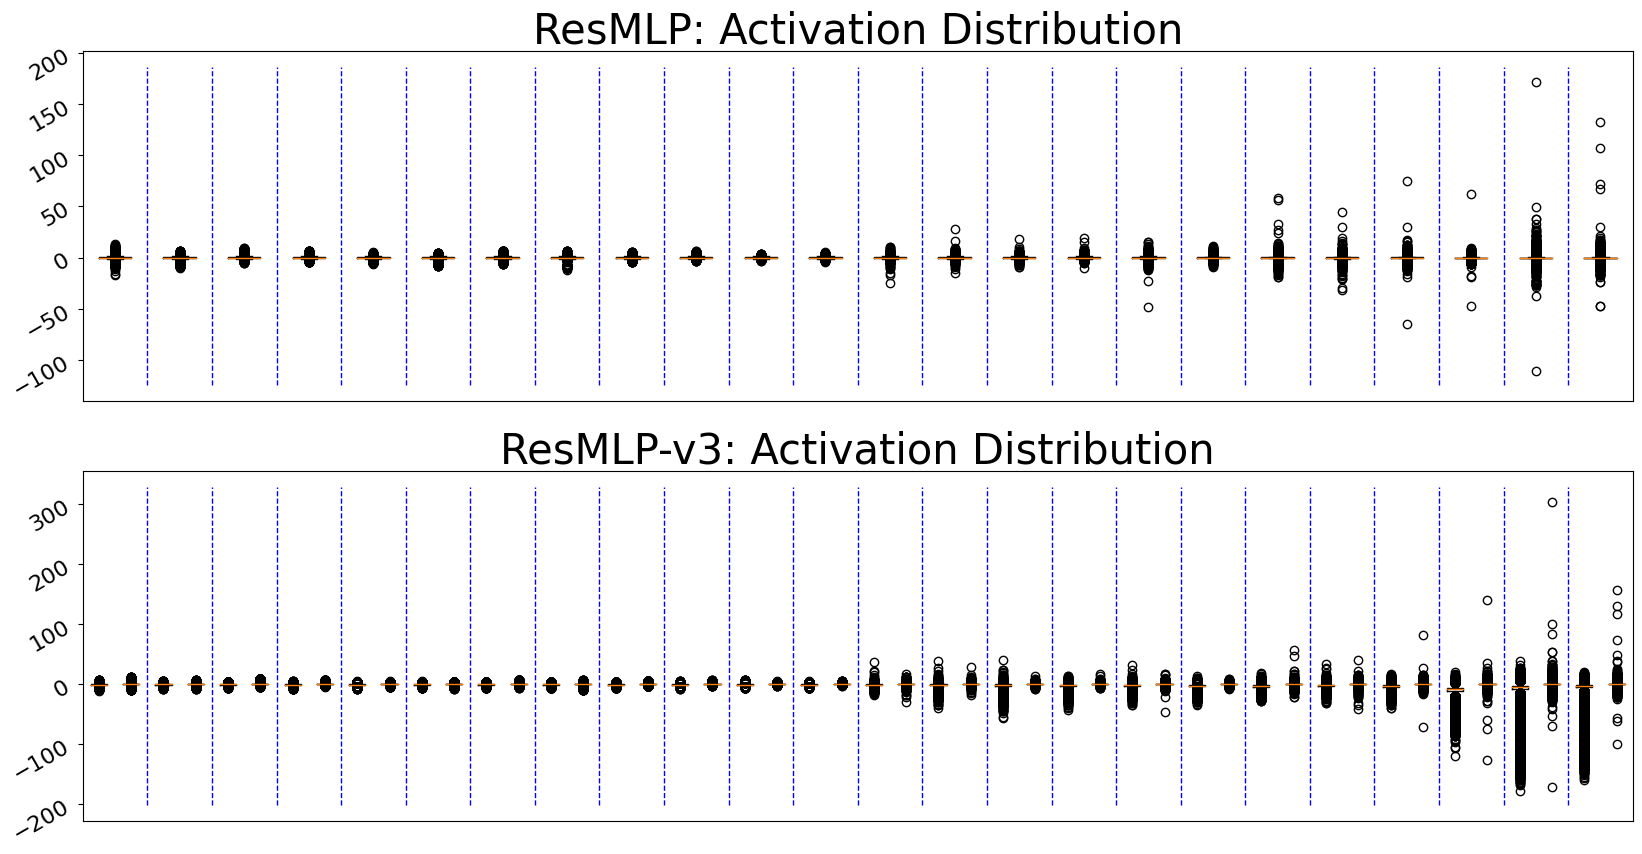

In [4]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
org_model.cuda()
act_dist(org_model, 0, 23, name='ResMLP: Activation Distribution', show_layers=["inner", "mlp.fc2"], ax=ax[0], real_sim=True)

# model2.cpu()
# cle_for_resmlp_v3(model2)
org_model.cuda()
act_dist(org_model, 0, 23, name='ResMLP-v3: Activation Distribution', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1], real_sim=True)